# AI model for predicting the electricity prices

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

from LSTMmodel import *
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

In [2]:
# moving to GPU if available (Metal)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


## Loading the data

In [3]:
# path to the CSV file
path = '../../data/fulldata.csv'

data = pd.read_csv(path)

display(data.head())
print(data.shape)

,SpotPriceDKK,from,to,temp_pca_1,temp_pca_2,temp_pca_3,wind_speed_pca_1,wind_speed_pca_2,wind_speed_pca_3,wind_speed_pca_4,...,mean_wind_dir_pca_39,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,oil_price,gas_price,constant
0,596.570007,2024-11-29 23:00:00+00:00,2024-11-30 00:00:00+00:00,-33.480249,7.339981,1.718044,3.248249,2.159318,0.612078,3.505092,...,-0.093112,-0.258819,0.965926,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
1,770.270020,2024-11-29 22:00:00+00:00,2024-11-29 23:00:00+00:00,-32.131543,8.173021,2.038769,2.387323,3.215623,0.288633,3.701821,...,-0.004524,-0.500000,0.866025,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
2,848.200012,2024-11-29 21:00:00+00:00,2024-11-29 22:00:00+00:00,-30.659681,8.780246,1.967827,1.620036,2.482432,0.516816,3.950176,...,-0.081036,-0.707107,0.707107,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
3,836.049988,2024-11-29 20:00:00+00:00,2024-11-29 21:00:00+00:00,-29.321284,9.297498,1.494915,1.490229,2.968878,1.071656,3.674438,...,-0.073105,-0.866025,0.500000,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1
4,894.219971,2024-11-29 19:00:00+00:00,2024-11-29 20:00:00+00:00,-27.818541,9.207599,0.853380,2.309477,2.890789,0.990981,2.872615,...,-0.040381,-0.965926,0.258819,-0.433884,-0.900969,-0.5,0.866025,72.940002,47.811001,1


(62280, 68)


## Data preprocessing

In [4]:
data['from'] = pd.to_datetime(data['from'])

# drop to column
data = data.drop(columns=['to'])

# explicitly including lagged prices as well
lag_hours = [0, 
            -1, -2, -3, -4, -5, -6, -24, #-48, -72, -96, -120, -144, -168
             ]
for lag in lag_hours:
    data[f'price_lag_{lag}'] = data['SpotPriceDKK'].shift(lag)

lag_oil_gas = [-24, -48, -72, # -168
               ]
for lag in lag_oil_gas:
    data[f'oil_price_{lag}'] = data['oil_price'].shift(lag)
    data[f'gas_price_{lag}'] = data['gas_price'].shift(lag)

# offset price by 1 day
data['SpotPriceDKK'] = data['SpotPriceDKK'].shift(24)
data['from'] = data['from'].shift(24)

time_features = ['hour', 'day', 'month']
for i in time_features:
    data[f'{i}_sin'] = data[f'{i}_sin'].shift(24)
    data[f'{i}_cos'] = data[f'{i}_cos'].shift(24)

# drop the first 24 rows
data = data.dropna()

# sort data to be ascending
data = data.sort_values('from')

display(data.head())
print(data.shape)

,SpotPriceDKK,from,temp_pca_1,temp_pca_2,temp_pca_3,wind_speed_pca_1,wind_speed_pca_2,wind_speed_pca_3,wind_speed_pca_4,wind_speed_pca_5,...,price_lag_-4,price_lag_-5,price_lag_-6,price_lag_-24,oil_price_-24,gas_price_-24,oil_price_-48,gas_price_-48,oil_price_-72,gas_price_-72
62207,96.019997,2017-10-27 00:00:00+00:00,11.237675,0.831761,0.323180,6.760909,2.790222,0.398300,3.612175,4.192237,...,210.059998,219.059998,222.639999,95.199997,58.439999,18.110001,58.330002,17.959999,57.369999,18.09
62206,95.349998,2017-10-27 01:00:00+00:00,11.377424,0.873795,0.021477,5.367659,1.404028,0.596286,4.109275,3.550561,...,201.720001,210.059998,219.059998,104.129997,58.439999,18.110001,58.330002,17.959999,57.369999,18.09
62205,141.729996,2017-10-27 02:00:00+00:00,11.360804,0.662414,-0.153373,4.258495,1.098352,-0.898239,4.812269,2.074639,...,194.720001,201.720001,210.059998,126.760002,58.439999,18.110001,58.330002,17.959999,57.369999,18.09
62204,178.720001,2017-10-27 03:00:00+00:00,11.961742,0.604866,-0.202105,3.781656,0.551939,-0.444115,4.825875,1.811022,...,186.460007,194.720001,201.720001,196.139999,58.439999,18.110001,58.330002,17.959999,57.369999,18.09
62203,238.199997,2017-10-27 04:00:00+00:00,12.162359,0.136666,-0.113291,3.029801,1.184454,-0.552593,5.198467,2.016204,...,185.720001,186.460007,194.720001,258.070007,58.439999,18.110001,58.330002,17.959999,57.369999,18.09


(62184, 81)


In [5]:
# extract column names
cols = data.columns.tolist()

# select features and target variable
all_features = cols[2:]
target = cols[:1]

print(f'Count of features before interaction terms: {len(all_features)}')
print(f'Target variable: {target}')

Count of features before interaction terms: 79
Target variable: ['SpotPriceDKK']


In [6]:
# training data: until July 2023
train_data = data[data['from'] < '2023-08-01']
# train_data = data[(data['from'] >= '2016-04-01') & (data['from'] < '2023-08-01')]

# validation data: July 2023 to December 2023
val_data = data[(data['from'] >= '2023-08-01') & (data['from'] < '2024-08-01')]

# Test data: 2024 and beyond
test_data = data[data['from'] >= '2024-08-01']

X_train = train_data[all_features].values
X_val = val_data[all_features].values
X_test = test_data[all_features].values

In [7]:
# initialize the scaler
scaler = StandardScaler()
# pca = PCA(n_components=0.95,svd_solver='full')

# fit the scaler on the training features and transform
X_train = scaler.fit_transform(X_train)

# transform the validation and test features using the same scaler
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
# # adding polynomial features, only interaction terms
# poly = PolynomialFeatures(degree=2)

# X_train = poly.fit_transform(X_train)
# X_val = poly.transform(X_val)
# X_test = poly.transform(X_test)

In [9]:
# extract target values
train_targets = train_data[target].values
val_targets = val_data[target].values
test_targets = test_data[target].values

## Model building

In [10]:
# set seed for reproducibility
torch.manual_seed(2024)
np.random.seed(2024)

# hyperparameters
seq_length = 24  # Use past 24 hours to form a sequence
batch_size = 256
input_dim = X_train.shape[1]
output_dim = 1
learning_rate = 0.001

# arrays for tuning
lambda_l1_array = [2e-1, 1e-1, 1e-2]
lambda_l2_array = [1e-4,1e-5, 1e-6]
hidden_dim_array = [256, 512]
layer_dim_array = [2, 3]

In [11]:
# create datasets
train_dataset = dataset(X_train, train_targets, seq_length)
val_dataset = dataset(X_val, val_targets, seq_length)
test_dataset = dataset(X_test, test_targets, seq_length)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# # initialize the model
# model = LSTMmodel(input_dim, hidden_dim, layer_dim, output_dim).to(device)

# loss evaluation function
criterion = nn.MSELoss()

# # optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Model training

In [12]:
# training the model
num_epochs = 150
patience = 10  # for early stopping
best_loss_global = np.inf

for hidden_dim in hidden_dim_array:
    for layer_dim in layer_dim_array:
        for lambda_l1 in lambda_l1_array:
            for lambda_l2 in lambda_l2_array:
                torch.manual_seed(2024)
                np.random.seed(2024)
                model = LSTMmodel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                # set seed for reproducibility
                best_loss = np.inf
                counter = 0

                # initialize lists to store loss values
                training_losses = []
                validation_losses = []

                for epoch in range(num_epochs):
                    model.train()
                    train_loss = 0
                    for X_batch, y_batch in train_loader:
                        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                        optimizer.zero_grad()

                        # forward pass
                        outputs = model(X_batch)

                        mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())

                        # L1 regularization
                        l1_loss = l1_regularization(model, lambda_l1)
                        l2_loss = l2_regularization(model, lambda_l2)

                        # calc total loss
                        loss = mse_loss + l1_loss + l2_loss

                        # backward pass and optimization
                        loss.backward()
                        optimizer.step()

                        train_loss += loss.item()


                    # average training loss
                    avg_train_loss = train_loss / len(train_loader)
                    training_losses.append(avg_train_loss)

                    # validation
                    model.eval()
                    val_losses = []
                    with torch.no_grad():
                        for X_batch, y_batch in val_loader:
                            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                            outputs = model(X_batch)
                            mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())
                            l1_loss = l1_regularization(model, lambda_l1)
                            l2_loss = l2_regularization(model, lambda_l2)
                            loss = mse_loss + l1_loss + l2_loss
                            val_losses.append(loss.item())

                    avg_val_loss = np.mean(val_losses)
                    validation_losses.append(avg_val_loss)
                    if (epoch + 1) % 10 == 0:
                        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
                    # torch.save(model.state_dict(), 'output/nn-paths/last_model.pth')
                    
                    # early stopping
                    if avg_val_loss < best_loss:
                        best_loss = avg_val_loss
                        counter = 0
                        # save the best model
                        torch.save(model.state_dict(), f'output/nn-paths/best_model_{lambda_l1_array.index(lambda_l1)}_{lambda_l2_array.index(lambda_l2)}_{hidden_dim_array.index(hidden_dim)}_{layer_dim_array.index(layer_dim)}_new.pth')
                        if best_loss < best_loss_global:
                            best_loss_global = best_loss
                            torch.save(model.state_dict(), f'output/nn-paths/best_model_global.pth')
                    else:
                        counter += 1
                        if counter >= patience:
                            print(f"Early stopping after {epoch} epochs. Best validation loss: {best_loss:.4f}")
                            break
                    
                    if epoch == (num_epochs - 1):
                        print(f"Training stopped after {epoch} epochs. Best validation loss: {best_loss:.4f}")


Epoch [10/150], Training Loss: 557282.4154, Validation Loss: 112091.4497
Epoch [20/150], Training Loss: 436604.7057, Validation Loss: 95640.5474
Epoch [30/150], Training Loss: 260666.1801, Validation Loss: 85453.8535
Early stopping after 38 epochs. Best validation loss: 81831.5795
Epoch [10/150], Training Loss: 557282.4421, Validation Loss: 112091.3992
Epoch [20/150], Training Loss: 483713.4107, Validation Loss: 102354.3291
Epoch [30/150], Training Loss: 264248.9059, Validation Loss: 80789.7969
Epoch [40/150], Training Loss: 169821.5610, Validation Loss: 86866.2045
Early stopping after 39 epochs. Best validation loss: 80789.7969
Epoch [10/150], Training Loss: 557282.4342, Validation Loss: 112091.3468
Epoch [20/150], Training Loss: 426441.3355, Validation Loss: 88989.5613
Epoch [30/150], Training Loss: 253045.7114, Validation Loss: 84135.0024
Epoch [40/150], Training Loss: 163765.0796, Validation Loss: 82929.3172
Early stopping after 44 epochs. Best validation loss: 79489.3537
Epoch [10

In [13]:
# load in the all the models and print the best validation loss
best_val_loss = np.inf
for hidden_dim in hidden_dim_array:
    for layer_dim in layer_dim_array:
        for lambda_l1 in lambda_l1_array:
            for lambda_l2 in lambda_l2_array:
                model = LSTMmodel(input_dim, hidden_dim, layer_dim, output_dim).to(device)
                try:
                    model.load_state_dict(torch.load(f'output/nn-paths/best_model_{lambda_l1_array.index(lambda_l1)}_{lambda_l2_array.index(lambda_l2)}_{hidden_dim_array.index(hidden_dim)}_{layer_dim_array.index(layer_dim)}_new.pth'))
                except:
                    continue
                model.eval()
                val_losses = []
                with torch.no_grad():
                    for X_batch, y_batch in val_loader:
                        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                        outputs = model(X_batch)
                        mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())
                        l1_loss = l1_regularization(model, lambda_l1)
                        l2_loss = l2_regularization(model, lambda_l2)
                        loss = mse_loss + l1_loss + l2_loss
                        val_losses.append(loss.item())

                avg_val_loss = np.mean(val_losses)

                predictions = []
                actuals = []
                with torch.no_grad():
                    for X_batch, y_batch in test_loader:
                        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                        outputs = model(X_batch)
                        predictions.extend(outputs.squeeze().tolist())
                        actuals.extend(y_batch.tolist())
                rmse = np.sqrt(mean_squared_error(actuals, predictions))
                mae = mean_absolute_error(actuals, predictions)

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_hidden_dim = hidden_dim
                    best_lambda_l1 = lambda_l1
                    best_lambda_l2 = lambda_l2
                    best_layer_dim = layer_dim
                    best_rmse = rmse
                    best_mae = mae
                print(f'Hidden dim:  {hidden_dim}, Layer dim: {layer_dim},  L1:    {lambda_l1},  L2:  {lambda_l2},    Validation Loss:     {avg_val_loss:.4f}')
                print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}')

print(f'Best: \n Hidden dim:  {best_hidden_dim}, Layer dim: {best_layer_dim},  L1:    {best_lambda_l1},  L2:  {best_lambda_l2},    Best Validation Loss:     {best_val_loss:.4f}')
print(f'Best RMSE: {best_rmse:.4f}, Best MAE: {best_mae:.4f}')

Hidden dim:  256, Layer dim: 2,  L1:    0.2,  L2:  0.0001,    Validation Loss:     81831.5795
RMSE: 345.0493, MAE: 260.6970
Hidden dim:  256, Layer dim: 2,  L1:    0.2,  L2:  1e-05,    Validation Loss:     80789.7969
RMSE: 342.9560, MAE: 258.6774
Hidden dim:  256, Layer dim: 2,  L1:    0.2,  L2:  1e-06,    Validation Loss:     79489.3537
RMSE: 345.9129, MAE: 265.1250
Hidden dim:  256, Layer dim: 2,  L1:    0.1,  L2:  0.0001,    Validation Loss:     76922.1695
RMSE: 359.0833, MAE: 275.4511
Hidden dim:  256, Layer dim: 2,  L1:    0.1,  L2:  1e-05,    Validation Loss:     76524.9302
RMSE: 355.8815, MAE: 272.4734
Hidden dim:  256, Layer dim: 2,  L1:    0.1,  L2:  1e-06,    Validation Loss:     80544.7124
RMSE: 364.0926, MAE: 277.7967
Hidden dim:  256, Layer dim: 2,  L1:    0.01,  L2:  0.0001,    Validation Loss:     77608.6619
RMSE: 366.2486, MAE: 279.6878
Hidden dim:  256, Layer dim: 2,  L1:    0.01,  L2:  1e-05,    Validation Loss:     76441.8731
RMSE: 368.7152, MAE: 277.9554
Hidden dim:

In [14]:
# current best hyperparameters
opt_hidden_dim = best_hidden_dim #512 # 512 seem to work best 256 can do
opt_layer_dim = best_layer_dim #2 dimensions seems to work best
opt_lambda_l1 =  best_lambda_l1 #1e-1 # 1e-1 seems to work best
opt_lambda_l2 = best_lambda_l2 #1e-4 # 1e-4, 1e-5 and 1e-6 all seem to work well, maybe 1-e6 is best

torch.manual_seed(2024)
np.random.seed(2024)
# initialize the model
model = LSTMmodel(input_dim, opt_hidden_dim, opt_layer_dim, output_dim).to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# training the model
num_epochs = 150
patience = 20  # for early stopping
best_loss = np.inf
counter = 0

# initialize lists to store loss values
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        # forward pass
        outputs = model(X_batch)

        mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())

        # L1 regularization
        l1_loss = l1_regularization(model, opt_lambda_l1)
        l2_loss = l2_regularization(model, opt_lambda_l2)

        # calc total loss
        loss = mse_loss + l1_loss + l2_loss

        # backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    # average training loss
    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            mse_loss = criterion(outputs.squeeze(), y_batch.squeeze())
            l1_loss = l1_regularization(model, opt_lambda_l1)
            l2_loss = l2_regularization(model, opt_lambda_l2)
            loss = mse_loss + l1_loss + l2_loss
            val_losses.append(loss.item())

    avg_val_loss = np.mean(val_losses)
    validation_losses.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    # torch.save(model.state_dict(), 'output/nn-paths/last_model.pth')
    
    # early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0
        # save the best model
        torch.save(model.state_dict(), 'output/nn-paths/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

Epoch [1/150], Training Loss: 819972.9716, Validation Loss: 267714.9478
Epoch [2/150], Training Loss: 723999.5728, Validation Loss: 202706.6448
Epoch [3/150], Training Loss: 650549.1856, Validation Loss: 157924.9350
Epoch [4/150], Training Loss: 599265.7985, Validation Loss: 142020.8088
Epoch [5/150], Training Loss: 575897.5581, Validation Loss: 116970.0650
Epoch [6/150], Training Loss: 540575.6586, Validation Loss: 105006.0461
Epoch [7/150], Training Loss: 493242.0717, Validation Loss: 90909.8087
Epoch [8/150], Training Loss: 456670.6158, Validation Loss: 81214.3232
Epoch [9/150], Training Loss: 423887.7098, Validation Loss: 77493.5648
Epoch [10/150], Training Loss: 393668.8062, Validation Loss: 72660.7407
Epoch [11/150], Training Loss: 369014.6494, Validation Loss: 71484.2146
Epoch [12/150], Training Loss: 344997.8730, Validation Loss: 72788.6515
Epoch [13/150], Training Loss: 321499.4538, Validation Loss: 69163.1465
Epoch [14/150], Training Loss: 302166.4936, Validation Loss: 68949.

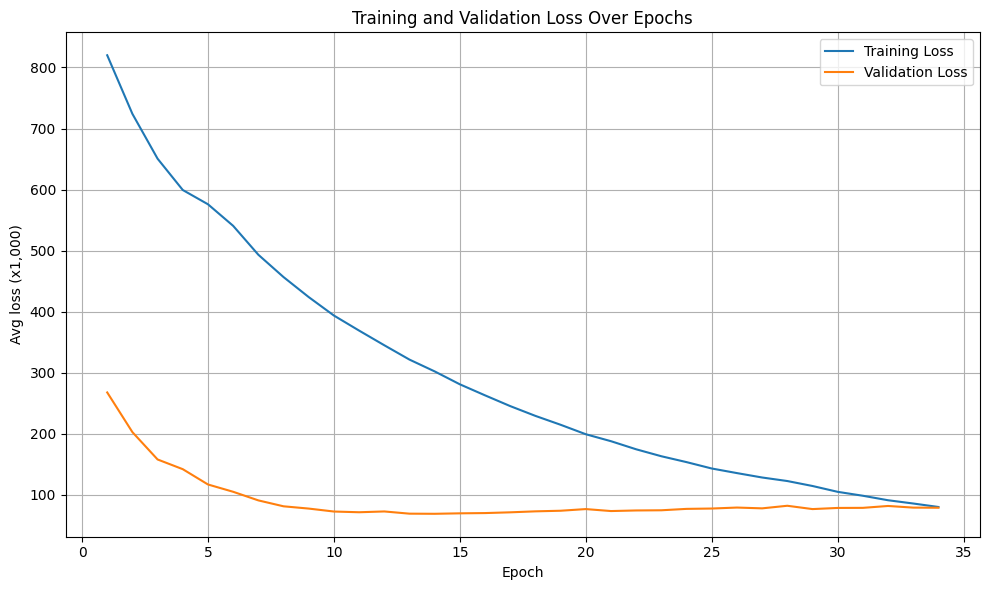

In [16]:
train_losses = np.array(training_losses)/1000
val_losses = np.array(validation_losses)/1000

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Avg loss (x1,000)')
# plt.yscale('log')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Model evaluation and plotting

In [17]:
# load the best model
model = LSTMmodel(input_dim, opt_hidden_dim, opt_layer_dim, output_dim).to(device)
# model.load_state_dict(torch.load(f'output/nn-paths/best_model_{lambda_l1_array.index(best_lambda_l1)}_{lambda_l2_array.index(best_lambda_l2)}_{hidden_dim_array.index(best_hidden_dim)}.pth'))
model.load_state_dict(torch.load('output/nn-paths/best_model.pth'))

model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions.extend(outputs.squeeze().tolist())
        #

        actuals.extend(y_batch.tolist())

rmse = np.sqrt(mean_squared_error(actuals, predictions))
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Performance on test data:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}')

Performance on test data:
RMSE: 341.6087
MAE: 261.8146


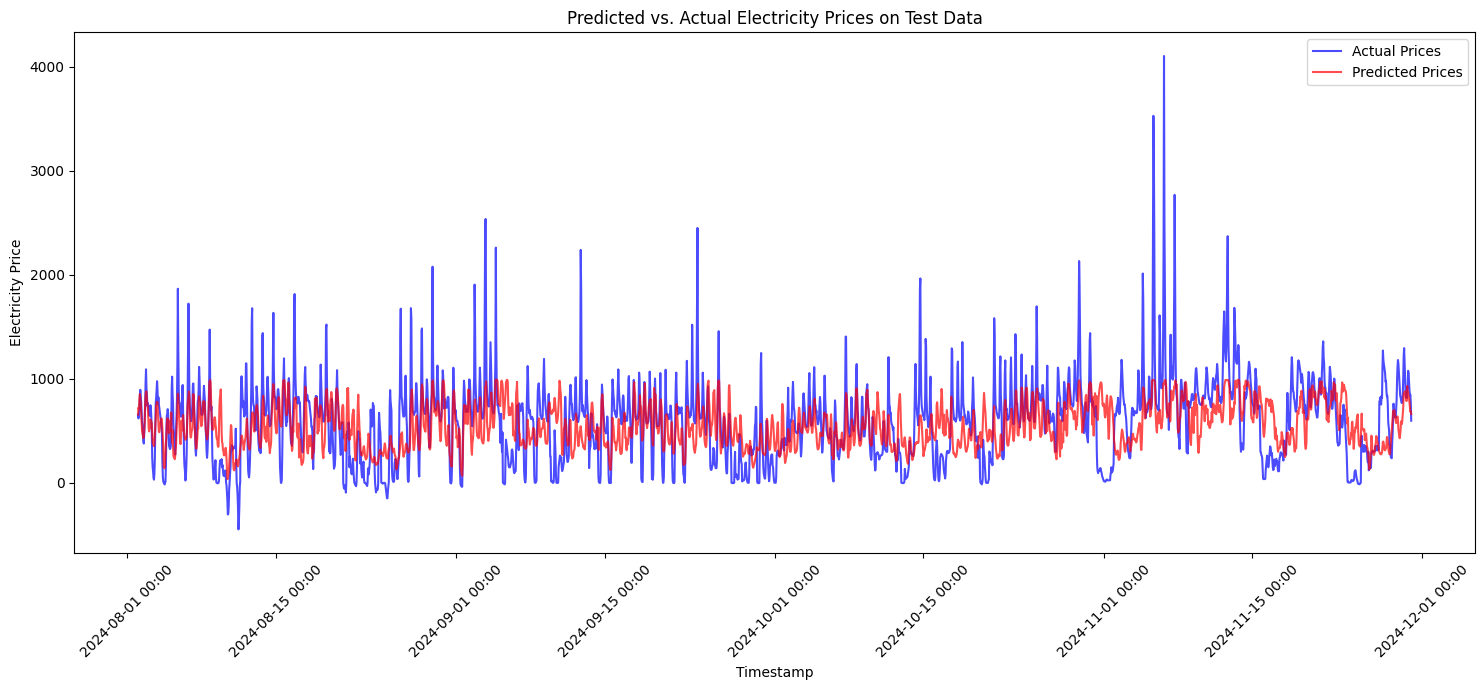

In [18]:
# convert 'predictions' and 'actuals' to numpy arrays
predictions = np.array(predictions)
actuals = np.array(actuals)

# extract 'from' timestamps from test_data, adjusted for seq_length
# since the dataset uses sequences, the first 'seq_length' targets are not included in 'actuals' and 'predictions'
test_timestamps = test_data['from'].values[seq_length:]

# ensure lengths match
min_length = min(len(test_timestamps), len(actuals), len(predictions))
test_timestamps = test_timestamps[:min_length]
actuals = actuals[:min_length]
predictions = predictions[:min_length]

# create the plot
plt.figure(figsize=(15, 7))
plt.plot(test_timestamps, actuals, label='Actual Prices', color='blue', alpha=0.7)
plt.plot(test_timestamps, predictions, label='Predicted Prices', color='red', alpha=0.7)
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Electricity Price')
plt.title('Predicted vs. Actual Electricity Prices on Test Data')

# format x-axis with date labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('output/nn-paths/lstm_predicted_vs_actual_prices2024.png')

plt.show()

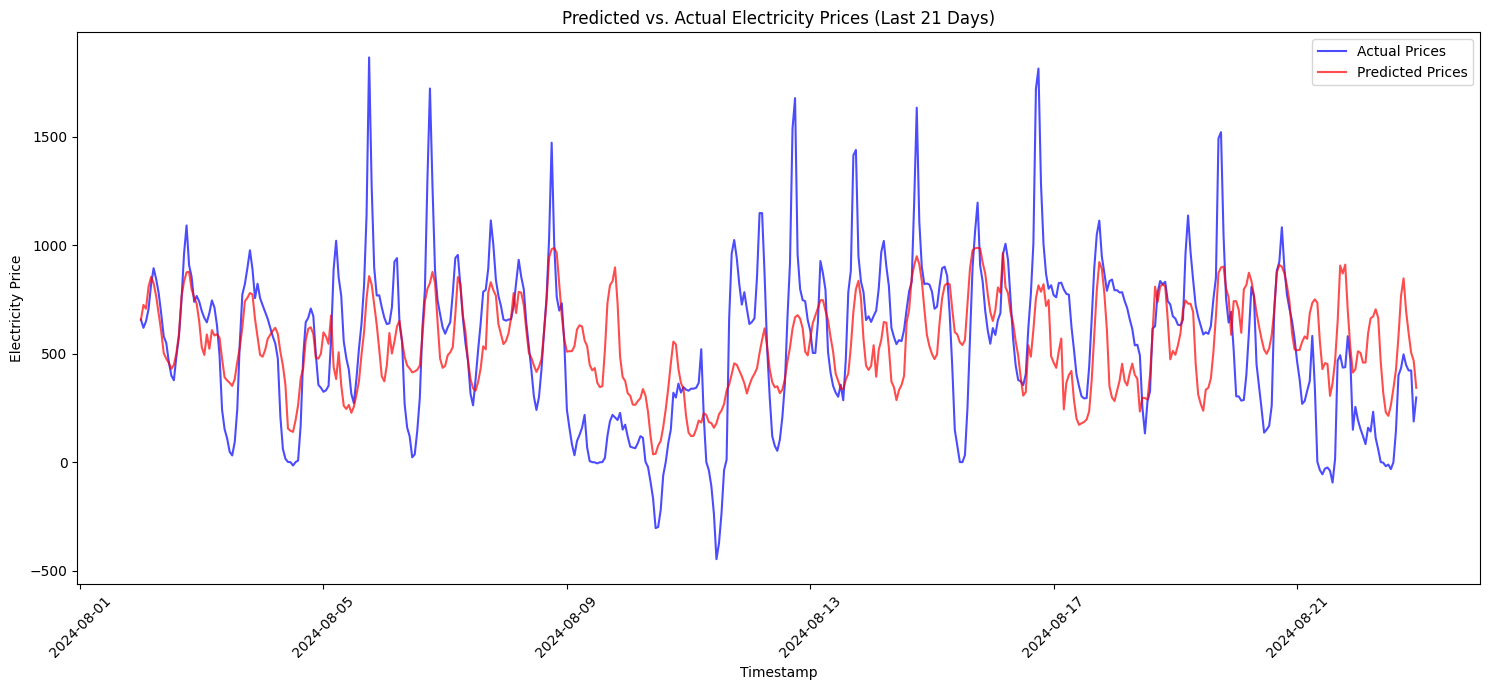

In [19]:
# plot the first 500 data points
datapoints = 24*21
plt.figure(figsize=(15, 7))
plt.plot(test_timestamps[:datapoints], actuals[:datapoints], label='Actual Prices', color='blue', alpha=0.7)
plt.plot(test_timestamps[:datapoints], predictions[:datapoints], label='Predicted Prices', color='red', alpha=0.7)
plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Electricity Price')
plt.title(f'Predicted vs. Actual Electricity Prices (Last {datapoints//24} Days)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(f'output/nn-paths/lstm_predicted_vs_actual_prices_last{datapoints//24}days.png')
plt.show()


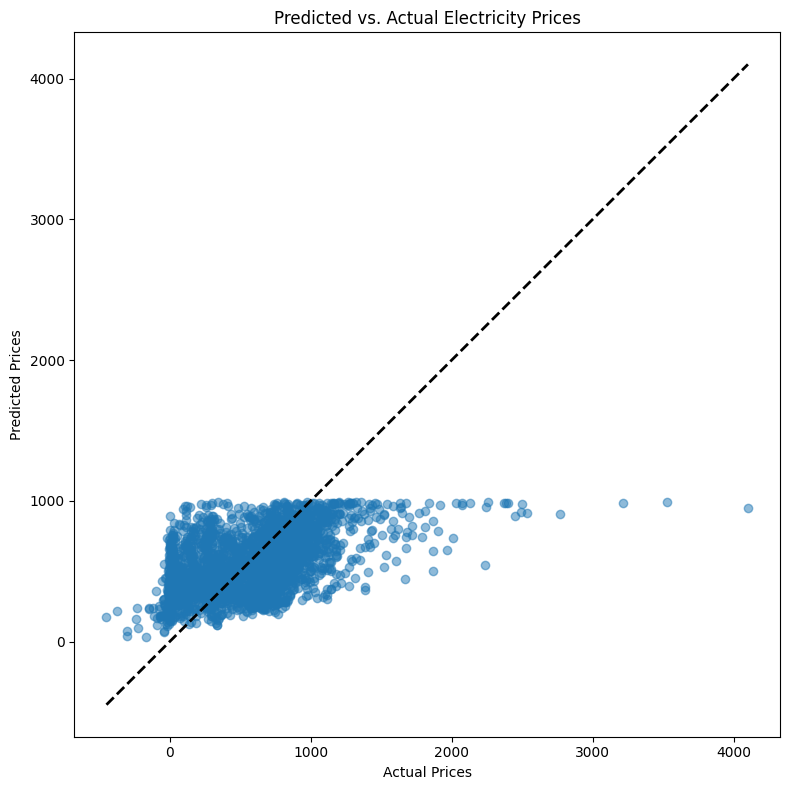

In [20]:
plt.figure(figsize=(8, 8))
plt.scatter(actuals, predictions, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Electricity Prices')

# Plot a diagonal line for reference
min_price = min(actuals.min(), predictions.min())
max_price = max(actuals.max(), predictions.max())
plt.plot([min_price, max_price], [min_price, max_price], 'k--', lw=2)
plt.tight_layout()

plt.savefig('output/nn-paths/lstm_predicted_vs_actual_prices_scatter.png')
plt.show()